In [2]:
import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

import IPython


# Import dei moduli che hai modificato
import sys
project_root = Path.cwd().parent

# 2. Aggiungilo a sys.path (convertendolo in stringa)
# abspath per sicurezza
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    print(f"Aggiunto al path: {project_root}")
sys.path.append('../src') # Assicurati che veda la cartella src
from src.data.dataset import PianoMmapDataset
from src.models.base_model import PianoGAN
from src.utils.tools import piano_roll_to_pretty_midi
from src.utils.visualization import display_prettymidi
# Set seed per riproducibilità
pl.seed_everything(42)

REPO_ROOT = Path('.').resolve().parent
if REPO_ROOT not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))


Aggiunto al path: /Users/Edoardo/Desktop/EDOARDO/UNI/MAGISTRALE/SECONDO_ANNO/NEURAL NETWORKS/NNDL-project


Seed set to 42


In [3]:
# 1. Configurazione Percorsi
DATA_DIR = REPO_ROOT / 'data'
MMAP_PREFIX = str(DATA_DIR / 'maestro') # Deve matchare il nome usato in preprocessing

# 2. Calcolo numero totale segmenti
# Un modo rapido è leggere la shape dal file _chords.dat che è piccolo
chords_path = f"{MMAP_PREFIX}_chords.dat"
if not Path(chords_path).exists():
    raise FileNotFoundError("Esegui prima main_preprocessing.ipynb!")

# I file .dat degli accordi sono (N, 8) uint8. 
# Dimensione file in byte = N * 8.
total_segments = Path(chords_path).stat().st_size // 8
print(f"Total segments found: {total_segments}")

# 3. Splitting (Copia esatta della logica di preprocessing)
all_indices = np.arange(total_segments)
train_idx, temp_idx = train_test_split(all_indices, test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

print(f"Train: {len(train_idx)} | Val: {len(val_idx)} | Test: {len(test_idx)}")

# 4. Dataset & Dataloaders
# Nota: num_workers=0 su Windows per evitare problemi con memmap, altrimenti puoi aumentarlo
train_ds = PianoMmapDataset(MMAP_PREFIX, train_idx)
val_ds   = PianoMmapDataset(MMAP_PREFIX, val_idx)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=0)

Total segments found: 39680
Train: 31744 | Val: 3968 | Test: 3968


In [4]:
# Iperparametri
NOISE_DIM = 100
LR = 0.0002

# Istanza del modello
model = PianoGAN(noise_dim=NOISE_DIM, learning_rate=LR)

# (Opzionale) Stampa riassunto
#print(model)

In [5]:
# Configurazione Checkpoint (salva il modello migliore)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath='../checkpoints',
    filename='pianogan-{epoch:02d}-{d_loss:.2f}',
    save_top_k=3,
    monitor='d_loss', # O un'altra metrica se la logghi
    mode='min'
)

trainer = pl.Trainer(
    accelerator='auto', # se lascio auto usa in automatico la GPU
    devices=1,
    max_epochs=10,
    callbacks=[checkpoint_callback],
)

# Avvio Training
print("Starting Training...")
trainer.fit(model, train_loader, val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Starting Training...


/Users/Edoardo/Desktop/EDOARDO/UNI/MAGISTRALE/SECONDO_ANNO/NEURAL NETWORKS/NNDL-project/venv_deep/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /Users/Edoardo/Desktop/EDOARDO/UNI/MAGISTRALE/SECONDO_ANNO/NEURAL NETWORKS/NNDL-project/checkpoints exists and is not empty.

  | Name          | Type          | Params | Mode  | FLOPs
----------------------------------------------------------------
0 | criterion     | BCELoss       | 0      | train | 0    
1 | generator     | Generator     | 1.9 M  | train | 0    
2 | discriminator | Discriminator | 122 K  | train | 0    
----------------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.229     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/Edoardo/Desktop/EDOARDO/UNI/MAGISTRALE/SECONDO_ANNO/NEURAL NETWORKS/NNDL-project/venv_deep/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/Edoardo/Desktop/EDOARDO/UNI/MAGISTRALE/SECONDO_ANNO/NEURAL NETWORKS/NNDL-project/venv_deep/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/Edoardo/Desktop/EDOARDO/UNI/MAGISTRALE/SECONDO_ANNO/NEURAL NETWORKS/NNDL-project/venv_deep/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not suppo

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

/Users/Edoardo/Desktop/EDOARDO/UNI/MAGISTRALE/SECONDO_ANNO/NEURAL NETWORKS/NNDL-project/venv_deep/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Using Apple MPS (Metal Performance Shaders) acceleration!
Generazione completata!
Previous bars shape: torch.Size([64, 1, 128, 16])
Current bars shape: torch.Size([64, 1, 128, 16])
Chords batch shape: torch.Size([64])
Example chord index: 4


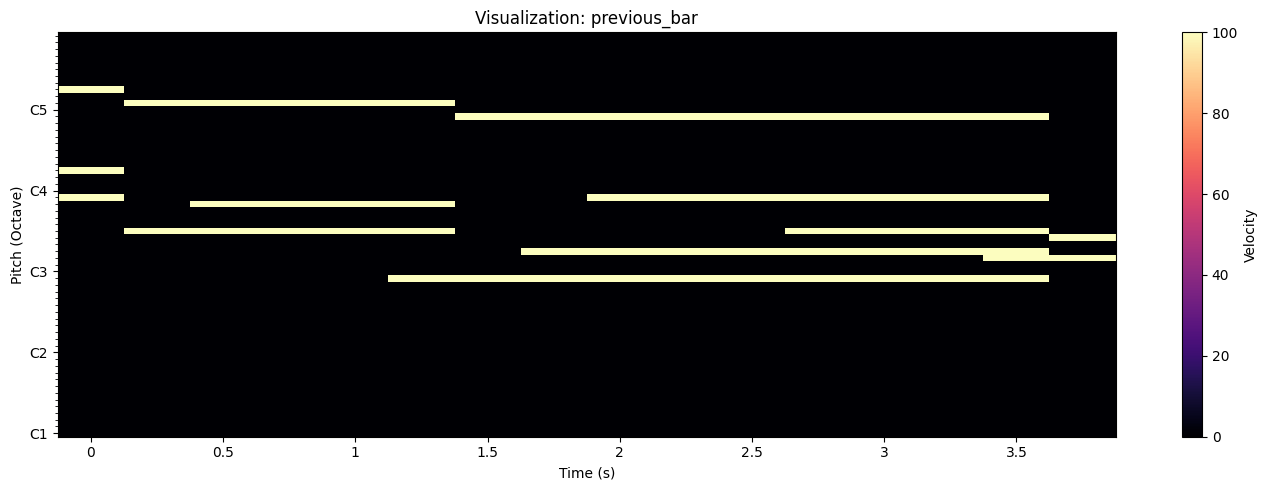

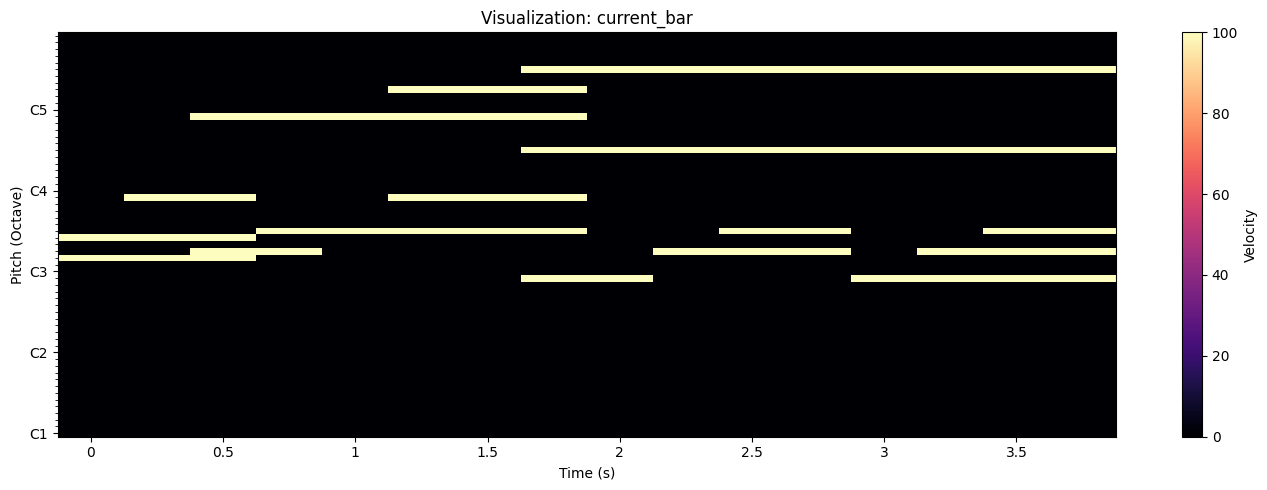

Concatenated bars shape: torch.Size([1, 128, 32])


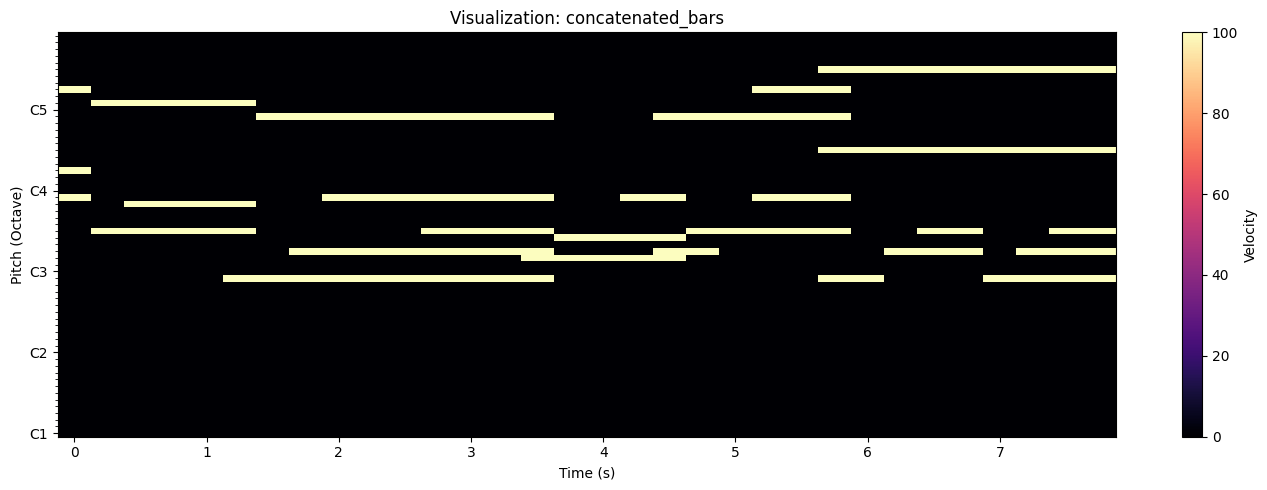

In [25]:
# Metti il modello in valutazione
# Rilevamento automatico del device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Se sei su un Mac con chip M1/M2/M3 (Apple Silicon), usa 'mps' per accelerazione hardware
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS (Metal Performance Shaders) acceleration!")
else:
    print(f"Using device: {device}")

# Sposta il modello sul device corretto
model.to(device)

# --- Ora procedi con la generazione ---
model.eval()

# Prepara i dati di test
prev, curr, chord = next(iter(val_loader))

# IMPORTANTE: Anche i tensori di input devono andare sullo stesso device!
prev = prev.to(device)
chord = chord.to(device)
noise = torch.randn(prev.size(0), 100, device=device)

# Genera
with torch.no_grad():
    generated_music = model(noise, prev, chord)

print("Generazione completata!")

# Visualize a sample from the DataLoader
# Estrai un batch

prev_bar, current_bar, chord_idx = next(iter(train_loader))

print("Previous bars shape:", prev_bar.shape)
print("Current bars shape:", current_bar.shape)
print("Chords batch shape:", chord_idx.shape)
print(f"Example chord index: {chord_idx[0].item()}") # Stampa l'indice dell'accordo del primo campione

# ho usato il codice di main_preprocessing per la visualizzazione

# forse andava normalizzato (lasciato al lettore per esercizio XD)
prev_pm = piano_roll_to_pretty_midi(prev_bar[1].squeeze().numpy()*100, fs=4)
display_prettymidi(
    prev_pm, 
    fs=4, 
    pitch_range=(24, 84),
    title=f"Visualization: previous_bar"
)
current_pm = piano_roll_to_pretty_midi(current_bar[1].squeeze().numpy()*100, fs=4)
display_prettymidi(
    current_pm, 
    fs=4, 
    pitch_range=(24, 84),
    title=f"Visualization: current_bar"
)

# Concatenate previous and current bars
concatenated_bars = torch.cat((prev_bar[1], current_bar[1]), dim=2)  # Concatenate along time axis
print("Concatenated bars shape:", concatenated_bars.shape)

concatenated_pm = piano_roll_to_pretty_midi(concatenated_bars.squeeze().numpy()*100, fs=4)
display_prettymidi(
    concatenated_pm, 
    fs=4, 
    pitch_range=(24, 84),
    title=f"Visualization: concatenated_bars"
)

audio = IPython.display.Audio(concatenated_pm.fluidsynth(fs=16000), rate=16000)
IPython.display.display(audio)